# 1. Понимание бизнеса

## 1.1 Цель
Предсказать качество вина от 0 до 10, где 10 вино самого высокого качества

## 1.2 Описание
Два набора данных относятся к красному и белому вариантам португальского вина «Vinho Verde». Ссылка [Cortez et al., 2009]. Из-за проблем с конфиденциальностью и логистикой доступны только физико-химические (входные) и органолептические (выходные) переменные (например, нет данных о сортах винограда, марке вина, продажной цене вина и т. д.).

Эти наборы данных можно рассматривать как задачи классификации или регрессии. Классы упорядочены и не сбалансированы (например, нормальных вин намного больше, чем отличных или плохих). Алгоритмы обнаружения выбросов можно использовать для определения нескольких отличных или плохих вин. Кроме того, мы не уверены, что все входные переменные релевантны. Так что было бы интересно протестировать методы выбора признаков.

[Описание от Kaggle](https://www.kaggle.com/datasets/rajyellow46/wine-quality)

# 2. Data Understanding

## 2.1 Import Libraries

In [100]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import  Normalizer , scale
from sklearn.model_selection import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

## 2.2 Вспомогательные функции

In [101]:
def plot_correlation_map(df: pd.DataFrame):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def plot_model_var_imp( model, X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 15 ].plot( kind = 'barh' )
    print (model.score( X , y ))

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )

## 2.3 Загрузка данных

In [102]:
wine = pd.read_csv('winequalityN.csv')
wine.shape

(6497, 13)

## 2.4 Статистика и визуализации

In [103]:
wine.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


**Описание переменных**

    0 - типа вина
    1 - фиксированная кислотность
    2 - летучая кислотность
    3 - лимонная кислота
    4 - остаточный сахар
    5 - хлориды
    6 - свободный диоксид серы
    7 - диоксид серы общий
    8 - плотность
    9 - рН
    10 - сульфаты
    11 - алкоголь

    Выходная переменная (на основе сенсорных данных):
    12 - качество (оценка от 0 до 10)
[Больше информации на сайте Kaggle](https://www.kaggle.com/datasets/rajyellow46/wine-quality)

### 2.4.1 Далее взглянем на некоторую ключевую информацию о переменных
Числовая переменная - это переменная со значениями в области целых или действительных чисел, в то время как категориальная переменная - это переменная, которая может принимать одно из ограниченного и обычно фиксированного числа возможных значений, таких как тип крови.


In [104]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


Наблюдаются незначительное количество пустых значений в признаках - fixed acidity, volatile acidity, citric acid, chlorides, pH, sulphates, residual sugar

In [105]:
wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


### 2.4.2 Тепловая карта корреляции может дать нам понимание того, какие переменные важны

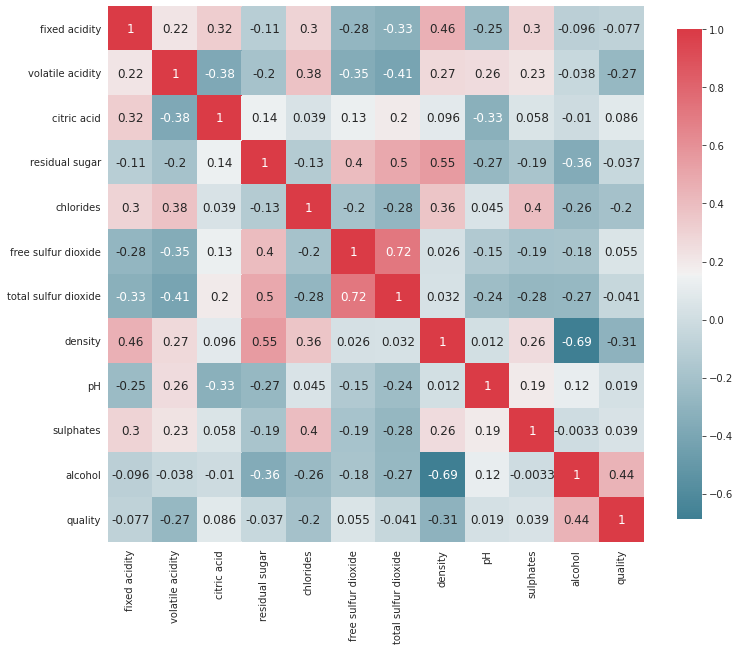

In [106]:
plot_correlation_map(wine)

Стоит выделить заметную корреляцию целевой переменной с alcohol, density, volatile acidity, chlorides


### 2.4.3 Давайте посмотрим сбалансированность данных по целевой переменной и типам вина

In [107]:
wine['quality'].unique()

array([6, 5, 7, 8, 4, 3, 9])

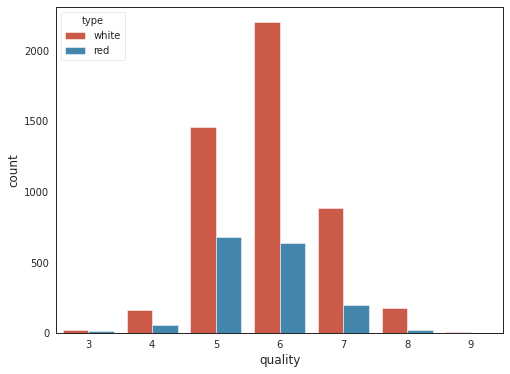

In [108]:
sns.countplot(data=wine, x="quality", hue="type")
plt.show()

Крайние знаения по качеству вина в датасете отсутствуют (0, 1, 2, 10).

Преобладают белые вина. 

Распределение оценки качества вина, визуально, близко к нормальному.

### 2.4.3 Давайте подробнее рассмотрим взаимосвязь между признаками и качеством вина


Посмотрим распределение значений признаков наиболее коррелируемых с целевой переменной

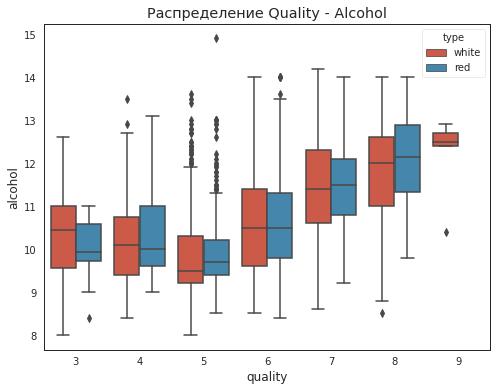

In [109]:
sns.boxplot(data=wine, x="quality", y="alcohol", hue='type')
plt.title('Распределение Quality - Alcohol')
plt.show()

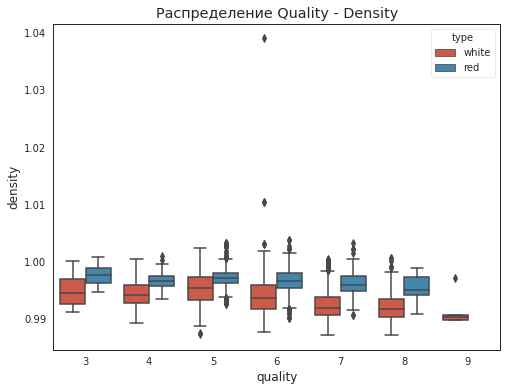

In [110]:
sns.boxplot(data=wine, x="quality", y="density", hue='type')
plt.title('Распределение Quality - Density')
plt.show()

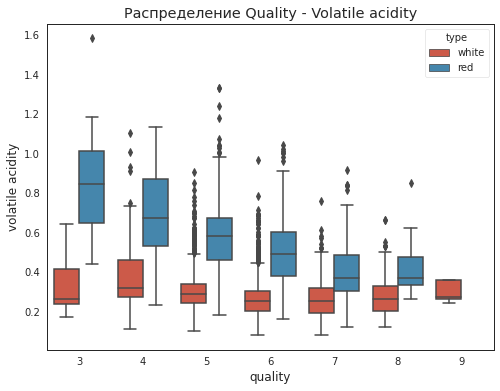

In [111]:
sns.boxplot(data=wine, x="quality", y="volatile acidity", hue='type')
plt.title('Распределение Quality - Volatile acidity')
plt.show()

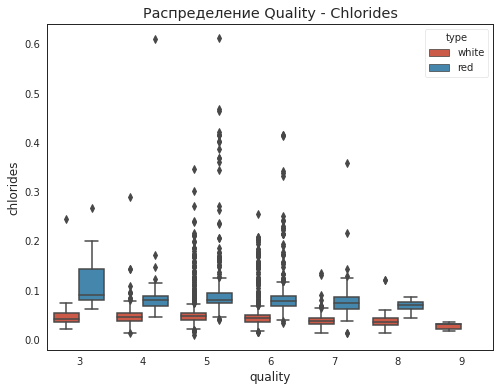

In [112]:
sns.boxplot(data=wine, x="quality", y="chlorides", hue='type')
plt.title('Распределение Quality - Chlorides')
plt.show()

# 3. Data Preparation

## 3.1 Категориальные переменные должны быть преобразованы в числовые переменные

Переменные type рассматриваются как категориальные переменные. Некоторые из  алгоритмов могут обрабатывать только числовые значения, поэтому нам нужно создать новую (фиктивную) переменную для каждого уникального значения категориальных переменных (OneHotEncoding)

In [113]:
# Transform type into binary values 0 and 1
type_wine = pd.Series( np.where( wine['type'] == 'red' , 1 , 0 ) , name = 'type' )

## 3.2 Заполнить пропущенные значения в переменных
Большинство алгоритмов машинного обучения требуют, чтобы все переменные имели значения, чтобы использовать их для обучения модели. Самый простой метод - заполнить пропущенные значения средним по переменной для всех наблюдений в обучающем наборе.

In [114]:
# Fill missing values of volatile acidity with the average of fixed acidity (mean)
wine['fixed acidity'] = wine['fixed acidity'].fillna(wine['fixed acidity'].mean())

# Fill missing values of volatile acidity with the average of volatile acidity (mean)
wine['volatile acidity'] = wine['volatile acidity'].fillna(wine['volatile acidity'].mean())

# Fill missing values of citric acid with the average of citric acid (mean)
wine['citric acid'] = wine['citric acid'].fillna(wine['citric acid'].mean())

# Fill missing values of chlorides with the average of chlorides (mean)
wine['chlorides'] = wine['chlorides'].fillna(wine['chlorides'].mean())

# Fill missing values of pH with the average of pH (mean)
wine['pH'] = wine['pH'].fillna(wine['pH'].mean())

# Fill missing values of sulphates with the average of sulphates (mean)
wine['sulphates'] = wine['sulphates'].fillna(wine['sulphates'].mean())

# Fill missing values of residual sugar with the average of residual sugar (mean)
wine['residual sugar'] = wine['residual sugar'].fillna(wine['residual sugar'].mean())

wine.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


## 3.3 Feature Engineering &ndash; добавляем новые признаки

Если постараться здесь можно что-то сделать

## 3.4 Сборка финальных датасетов для моделирования

### 3.4.1 Variable selection
Выбираем признаки для формирования итогового датасет. У нас доступны признаки:

 - wine 
 - type_wine

In [115]:
wine_X = pd.concat( [ wine.drop(['type', 'quality'], 1) , type_wine] , axis=1 )
wine_X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,0
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,0


### 3.4.2 Создание датасетов

Отделяем данные для обучения и для проверки

In [116]:
X_train, X_test, y_train, y_test = train_test_split(
    wine_X, wine['quality'], stratify=wine['quality'], test_size=0.25, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4872, 12), (1625, 12), (4872,), (1625,))

### 3.4.3 Важность признаков
Отбор оптимальных признаков для модели имеет важное значение. Теперь мы попытаемся оценить, какие переменные являются наиболее важными, чтобы сделать прогноз.

1.0


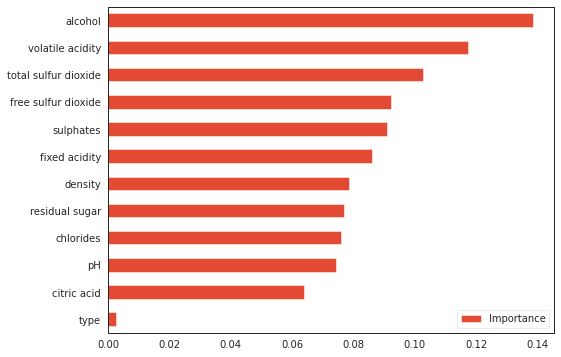

In [117]:
plot_variable_importance(X_train, y_train)

# 4. Моделирование
Теперь мы выберем модель, которую хотели бы попробовать. Используем обучающий набор данных для обучения модели и затем проверим ее с помощью тестового набора.

## 4.1 Выбор модели
Хорошей отправной точкой для задачи классификации является логистическая регрессия.

In [118]:
model = LogisticRegression(random_state=42)

## 4.2 Обучение модели

In [119]:
model.fit(X_train, y_train)

LogisticRegression(random_state=42)

# 5. Оценка
Теперь мы собираемся оценить модель

## 5.1 Модель
Мы можем оценить точность модели, используя набор для валидации, где мы знаем фактический результат. Этот набор данных не использовался для обучения, поэтому он абсолютно новый для модели.

Затем мы сравниваем точность с точностью при использовании модели на тренировочных данных. Если разница между ними значительна, это свидетельствует о переобучении. Мы стараемся избегать этого, потому что это означает, что модель не будет хорошо обобщаться на новые данные (будет работать плохо)

In [120]:
from sklearn.metrics import classification_report

print('Train score:\n', classification_report(model.predict(X_train), y_train))

Train score:
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.44      0.50      0.47      1411
           6       0.75      0.47      0.57      3411
           7       0.02      0.38      0.04        50
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

    accuracy                           0.48      4872
   macro avg       0.17      0.19      0.16      4872
weighted avg       0.65      0.48      0.54      4872



In [121]:
print('Test score:\n', classification_report(model.predict(X_test), y_test))

Test score:
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.47      0.50      0.48       496
           6       0.74      0.47      0.57      1112
           7       0.01      0.25      0.03        16
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         0

    accuracy                           0.48      1625
   macro avg       0.17      0.17      0.16      1625
weighted avg       0.65      0.48      0.54      1625



# 6. Развертывание


In [122]:
y_pred = model.predict(X_test)
wine_id = X_test.index
submit = pd.DataFrame({'id': wine_id, 'y_test': y_test, 'y_pred': y_pred} )
submit.to_csv( 'submition.csv' , index = False )
submit.head()

,id,y_test,y_pred
189,189,4,5
284,284,5,5
1289,1289,6,6
1135,1135,6,6
188,188,8,6
